<a href="https://colab.research.google.com/github/rdoEdoa/EESAM/blob/main/LearningCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning curves
A learning curve shows the validation and training scores of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.


## Importing packages and functions
- [numpy](https://numpy.org) is a python package that provides support for more efficient numerical computation
- [pandas](https://pandas.pydata.org) is a convenient library that supports dataframes. Pandas is technically optional because [Scikit-Learn](https://scikit-learn.org) can handle numerical matrices directly, but it will make our lives easier, as we will see later.
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) is a python class that implements the Linear Regression model.
- [learning_curve()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) generates the learning curve for a varying size of training dataset.
- [matplotlib](https://matplotlib.org/) is a python package that will be used later for plotting.

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Importing data
Let us now read the data for this lab. They are **real**, not synthetic, and come from Turkish researchers Pınar Tüfekci and Heysem Kaya, and can be downloaded from the URL below (the original is [here](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant)).
As the data is stored in an .xlsx file, we use pandas’ read_excel() function to read it in, show the data format, and print the first three lines.
A "[dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html)" in pandas (and in other ML frameworks such as R) is a class that includes
- a data set (in this case 5 columns and 9567 lines)
- some format information, such as the column names (from the xlsx header), the data types and so on
- methods to print mean, standard deviation and so on.

In [ ]:
dataset_url = 'https://raw.githubusercontent.com/lavagno/eesam/main/Folds5x2_pp.xlsx'
electricity = pd.read_excel(dataset_url)
print("Some generic information about the dataframe:")
print(electricity.info())
print("The first three rows of the dataframe:")
print(electricity.head(3))
print("The mean of each column:")
print(electricity.mean())
print("The standard deviation of each column:")
print(electricity.std())

The PE column is the target variable (i.e. the output of the ML prediction), and it describes the net hourly electrical energy output. All the other variables are potential features, and the values for each are actually hourly averages (not net values, like for PE). The electricity is generated by gas turbines, steam turbines, and heat recovery steam generators. According to the documentation of the data set, the vacuum level has an effect on steam turbines, while the other three variables affect the gas turbines. Consequently, we will use all of the feature columns in our regression models. At this step we would normally put aside a test set, explore the training data thoroughly, remove any outliers, measure correlations, etc. For this lab's purposes, however, we will assume that’s already done and jump straight to generate some learning curves. Before we start that, it is worth noticing that there are no missing values (i.e. the data have already been "cleaned" for us). Also, the numbers are unscaled, but they are not too far apart, so we should not have too many problems without scaling. We will cover scaling (subtracting mean, dividing by std) in later labs.



## Selecting various training set sizes
First of all, we need to select a few training set sizes, to see what impact the amount of data has on the training error and the validation error.

From the lessons, you should remember that:
*   The training error for a **given model** should go **up** with the amont of data, because it becomes difficult to fit the actual data variance into the fixed model, and hence the model suffers from **increased bias**.
*   The validation error for that model should go **down** with the amount of training data, because the model is shown more and more variance among the data, and hence it becomes better in the presence of **unseen variance** from the validation set.

The minimum number of data is of course 1. Technically, to "learn" a linear model with 4 **independent** features (the features in this case are most likely not independent; we will look into that later), hence with 5 independent parameters (4 weights for 4 features, plus a bias), we need a minimum of 5 data items. So we know a priori that datasets with 5 less than 5 elements will be meaningless.

The maximum is given by the number of instances in the training set. Our training set has 9568 instances, so the maximum value is 9568.

However, we have not yet put aside a validation set. We will do that using an 80:20 ratio, ending up with a training set of 7654 instances (80%), and a validation set of 1914 instances (20%). Given that our training set will have 7654 instances, the maximum value we can use to generate our learning curves is 7654. For our case, here, we use these 9 **logarithmically distributed** sizes (to optimize the visibility of changes):

In [ ]:
train_sizes = [1, 3, 10, 30, 100, 300, 1000, 5000, 7654]

## The learning_curve function

We will use the [`learning_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) function from the scikit-learn library to generate a learning curve for a regression model. There is no need on our part to put aside a validation set because `learning_curve()` will take care of that. In the code cell below, we:
- Declare the features and the target.
- Use learning_curve() to generate the data needed to plot a learning curve.

The function returns a tuple containing three elements:
  1. the vector of training set sizes,
  2. the vector of error scores on the training sets
  3. the vector of error scores on the validation sets.

The function takes (among many others) the following parameters:
 1. The `estimator` argument indicates the learning algorithm we use to estimate the true model, in this case [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
 1. The `X` argument contains the features;
 1. The `y` argument contains the target;
 1. The `train_sizes` argument specifies the training set sizes to be used;
 1. The `cv` argument determines the cross-validation splitting strategy (we will discuss this immediately below);
 1. The `scoring` argument indicates the error metric to use. The intention is to use the mean squared error (MSE) metric, but that is not a possible parameter for scoring, because the function expects a metric where **larger is better** (the full list is [here](https://scikit-learn.org/stable/modules/model_evaluation.html)). We will use the closest approximation, negative MSE (accuracy would have been another option), and we will just have to change its sign later on.


In [ ]:
features = ['AT', 'V', 'AP', 'RH']
target = 'PE'
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
X = electricity[features],
y = electricity[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

We already know what is in `train_sizes` (they are our vector `[1, 3, ... 7654]`). Let us inspect the other two variables to see what `learning_curve()` returned:

In [ ]:
print('Training scores:', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('Validation scores:', validation_scores)

## Analysis of the results
Since we specified 9 training set sizes, you might have expected 9 values for each kind of score. Instead, we got 9 rows for each, and every row has 5 error scores. This happens because learning_curve() runs a **k-fold cross-validation** under the hood, where the value of k is given by what we specify for the `cv` parameter. In our case, `cv = 5`, so there will be five splits. For each split, an estimator is trained for every training set size specified.

In this way we can better estimate the **variance** of each score. As expected, with small data sets variance is **huge**, since it is unlikely that those few data are good representatives of the total population.

A few observations:
1. For 1 training datum, the training error is 0, because a straight line can fit exactly any 1- or 2-point dataset. Of course the validation error is huge, because with just 1 datum we cannot even guess correctly the 5 parameters of our model (4 weights and one bias). Hence this part of the lerning curve will not be realistic, but it will give us an idea of what happens when we have too few data to learn all the parametrs of the model.
2. With larger and larger dataset variance goes down, and that is a **good indication that above roughly 100 samples we have included enough data to properly train our model**.
3. **The training and validation error curves converge**, and that means again that **we are not experiencing overfitting**, i.e. we do not see too little variance in the training data with respect to the large variance of the "true population" (represented by the validation set).
4. The final mean squared errors are fairly low (the square root of 20 is about 4.5, while the mean value of PE is about 450, hence we are about 1% off the true prediction).
5. The values of columns 2, 3, 4 and 5 of the training error the smaller datasets are identical, e.g. (your actual values may be different, due to different random number generator seeds):
```
[-3.23117427e-27 -6.57005434e-26 -6.57005434e-26 -6.57005434e-26
  -6.57005434e-26]
```
“Once is happenstance. Twice is coincidence. Three times is enemy action” (I. Fleming)

In this case, there is a reason (hence it's enemy action :-) ). When the cardinality M of selected training data is small, N-fold cross-validation will **always choose the first M elements of the dataset from the second training onwards**, as shown in this picture:
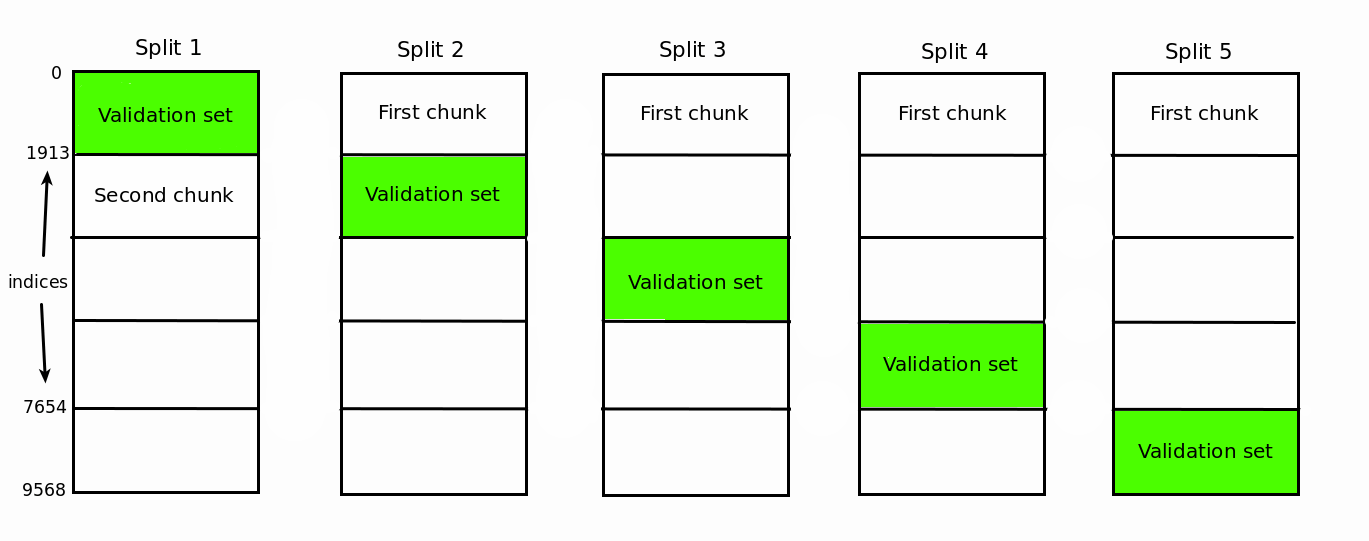

To avoid this effect, in reality we would need to set the `shuffle` parameter of `learning_curve()` to `True`. This will ensure a random selection of the training set, and will move you closer to being true professionals :-).


## Plotting the learning curves
While we can already see such trends from the raw data, a picture is worth a thousand words. Hence we will first **compute** and then **plot** the mean validation error (a true professional would plot both mean and mean+/-std, but for now the mean is enough).

The [`Series()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) class from pandas uses the train_scores_mean vector, that is obtained applying the - vector operation to the `train_scores.mean` vector that is obtained by applying the `mean()` function along the first axis (array rows) to the `train_scores` array. `Series()` converts the two input array into a dictionary, that can then be printed, plotted and manipulated, using the first array as a content, and the second array as a hash index.

This should give you an idea of what a modern tensor-oriented programming language such as numpy, matlab or R, offers. In this case we could simply have appended the `train_sizes` array to the `train_scores_mean` array, and printed pretty much the same result. But, as you know, a dictionary is much more powerful than an array. We will not exploit it further here, but you can find it useful later.

In [ ]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

We plot the learning curves using the matplotlib library, using a log scale for the X axis, so that our training data sizes are equally spaced.
The meaning of the various functions and arguments should be obvious. The `ylim` y axis limit must be used because the initial validation error is so huge that it would make the graph unreadable.

In [ ]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xscale("log")
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,40)

## Summary
As you can see from the learning curves:
- they **converge** around 1000 samples,
- they are **practically indistinguishable** when we use the full data set.
- the square root of the MSE (4.5) is about 1/4 of the standard deviation of the target.

This roughly means that:
- the model that we have chosen (Linear Regression) **may be** good enough for the data (no huge underfitting, no significant overfitting).
- when we use 80% of the full data set as training set, we have enough data and the model is actually learning from the training set how to model the entire population (as represented by the validation set).

If we want to be sure that the model is not underfitting too much, we could try to explore Polynomial Regression, as was done in the previous lab.

Remember:
*   **Overfitting can be detected** if the validation error is significantly higher than the training error.
*   **Underfitting cannot be detected from the errors alone**, but requires you to
  * either declare yourself happy with what you achieved
  * or try increasing the model complexity until you start overfitting, and then regularize.



## Your tasks
Repeat the experiment that you did with Lasso regularization in the lab on **Linear and Polynomial Regression and regularization**, to analyze if some of the features of **this** dataset (on power plants) are redundant, i.e. their weights can be made close to zero without increasing the MSE too much. Do not add powers or cross-products of the features, i.e. do not use polynomial regression this time, only linear regression as above.
Note that the learning_curves class does not give you access to the model parameters

In [ ]:
X = electricity[features],
y = electricity[target]
ridge_steps = [
    ('scalar', StandardScaler()),
    ('model', Lasso(alpha=0.1))
]

ridge_pipe = Pipeline(ridge_steps)
ridge_pipe.fit(X, y)


Credits: the lab was mostly taken from [here](https://www.dataquest.io/blog/learning-curves-machine-learning/).